In [1]:
import pandas as pd
import numpy as np

Data Exploration 

1. How many observations does your dataset have?

In [2]:
total_observations = 0

# Load each dataset file 
weekly_offense = pd.read_csv('Data/weekly_player_stats_offense.csv')
weekly_defense = pd.read_csv('Data/weekly_player_stats_defense.csv')
yearly_offense = pd.read_csv('Data/yearly_player_stats_offense.csv')
yearly_defense = pd.read_csv('Data/yearly_player_stats_defense.csv')
weekly_team_offense = pd.read_csv('Data/weekly_team_stats_offense.csv')
weekly_team_defense = pd.read_csv('Data/weekly_team_stats_defense.csv')
yearly_team_offense = pd.read_csv('Data/yearly_team_stats_offense.csv')
yearly_team_defense = pd.read_csv('Data/yearly_team_stats_defense.csv')

# Count observations in each file
print("Weekly Player Stats (Offense):")
print(f"Observations: {len(weekly_offense):,}")
print(f"Features: {len(weekly_offense.columns)}")
total_observations += len(weekly_offense)

print("\nWeekly Player Stats (Defense):")
print(f"Observations: {len(weekly_defense):,}")
print(f"Features: {len(weekly_defense.columns)}")
total_observations += len(weekly_defense)

print("\nYearly Player Stats (Offense):")
print(f"Observations: {len(yearly_offense):,}")
print(f"Features: {len(yearly_offense.columns)}")
total_observations += len(yearly_offense)

print("\nYearly Player Stats (Defense):")
print(f"Observations: {len(yearly_defense):,}")
print(f"Features: {len(yearly_defense.columns)}")
total_observations += len(yearly_defense)

print("\nWeekly Team Stats (Offense):")
print(f"Observations: {len(weekly_team_offense):,}")
print(f"Features: {len(weekly_team_offense.columns)}")
total_observations += len(weekly_team_offense)

print("\nWeekly Team Stats (Defense):")
print(f"Observations: {len(weekly_team_defense):,}")
print(f"Features: {len(weekly_team_defense.columns)}")
total_observations += len(weekly_team_defense)

print("\nYearly Team Stats (Offense):")
print(f"Observations: {len(yearly_team_offense):,}")
print(f"Features: {len(yearly_team_offense.columns)}")
total_observations += len(yearly_team_offense)

print("\nYearly Team Stats (Defense):")
print(f"Observations: {len(yearly_team_defense):,}")
print(f"Features: {len(yearly_team_defense.columns)}")
total_observations += len(yearly_team_defense)

print(f"TOTAL OBSERVATIONS: {total_observations:,}")

Weekly Player Stats (Offense):
Observations: 58,629
Features: 393

Weekly Player Stats (Defense):
Observations: 117,993
Features: 116

Yearly Player Stats (Offense):
Observations: 7,133
Features: 660

Yearly Player Stats (Defense):
Observations: 16,148
Features: 149

Weekly Team Stats (Offense):
Observations: 7,088
Features: 115

Weekly Team Stats (Defense):
Observations: 7,088
Features: 65

Yearly Team Stats (Offense):
Observations: 582
Features: 99

Yearly Team Stats (Defense):
Observations: 582
Features: 47
TOTAL OBSERVATIONS: 215,243


2. Describe all columns in your dataset their scales and data distributions. Describe the categorical and continuous variables in your dataset. Describe your target column and if you are using images plot some example classes of the images.

In [3]:
# COLUMN ANALYSIS AND DATA DISTRIBUTIONS
print("COLUMN ANALYSIS - NFL DATASET")

# Focus on the main datasets for fantasy football
main_datasets = {
    'Weekly Offensive Stats': weekly_offense,
    'Yearly Offensive Stats': yearly_offense,
    'Weekly Defensive Stats': weekly_defense,
    'Yearly Defensive Stats': yearly_defense
}

for name, df in main_datasets.items():
    print(f"\n {name.upper()}")    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.shape[1]}")
    
    # Data types overview
    print(f"\nData Types Summary:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  • {dtype}: {count} columns")
    

COLUMN ANALYSIS - NFL DATASET

 WEEKLY OFFENSIVE STATS
Shape: (58629, 393)
Columns: 393

Data Types Summary:
  • float64: 379 columns
  • object: 8 columns
  • int64: 6 columns

 YEARLY OFFENSIVE STATS
Shape: (7133, 660)
Columns: 660

Data Types Summary:
  • float64: 647 columns
  • object: 8 columns
  • int64: 5 columns

 WEEKLY DEFENSIVE STATS
Shape: (117993, 116)
Columns: 116

Data Types Summary:
  • float64: 100 columns
  • object: 9 columns
  • int64: 7 columns

 YEARLY DEFENSIVE STATS
Shape: (16148, 149)
Columns: 149

Data Types Summary:
  • float64: 135 columns
  • object: 7 columns
  • int64: 7 columns


Dataset Column Description</br>
Our dataset is a comprehensive collection of NFL statistics from 1999-2022, comprising 215,243 total observations distributed across eight CSV files. The data have two primary axes: (weekly vs. yearly) and (player vs. team), which is ideal for our goal of building a fantasy football autodrafter.

Player-Level Data (Primary Focus):

Weekly Offensive Stats (58,629 observations): This is the most critical dataset for our project. Each observation represents a single player's offensive performance in one game. </br>
Yearly Offensive Stats (7,133 observations): Adding all weekly data (16 - 17 games) into a full-season summary for each player, useful for establishing a baseline performance. </br>
Defensive Stats (Weekly & Yearly): While our primary focus is offense, the 117,993 weekly and 16,148 yearly defensive observations will be used for drafting team defenses (D/ST)</br>
Team-Level Data (Contextual): The team-level files provide broader context on team tendencies (e.g., pass-heavy vs. run-heavy offenses) that can influence a player's opportunity and projected output.</br>

In [4]:

print("Analysis of Categorical vs. Continuous Variables (from weekly_offense)")

categorical_cols = []
continuous_cols = []

# Check each column individually
for col in weekly_offense.columns:
    if weekly_offense[col].dtype == 'object':
        # Text columns are categorical
        categorical_cols.append(col)
    elif weekly_offense[col].nunique() <= 30:
        categorical_cols.append(col)
    else:
        continuous_cols.append(col)

# Print results
print(f"\nCategorical Columns ({len(categorical_cols)} total):")
print("Examples:", categorical_cols[:5])

print(f"\nContinuous Columns ({len(continuous_cols)} total):")  
print("Examples:", continuous_cols[:5])


Analysis of Categorical vs. Continuous Variables (from weekly_offense)

Categorical Columns (84 total):
Examples: ['season', 'week', 'player_id', 'draft_year', 'draft_round']

Continuous Columns (309 total):
Examples: ['offense_snaps', 'offense_pct', 'team_offense_snaps', 'birth_year', 'draft_pick']

Categorical Columns (84 total):
Examples: ['season', 'week', 'player_id', 'draft_year', 'draft_round']

Continuous Columns (309 total):
Examples: ['offense_snaps', 'offense_pct', 'team_offense_snaps', 'birth_year', 'draft_pick']


For our fantasy football autodrafter, the dataset does not have a pre-made target column. </br>
Our target variable will be 'fantasy_points', which we will need to create. </br>
How it will be created: </br>
We will calculate it based on standard fantasy scoring rules applied to the continuous variables. </br>
For example, in a Points Per Reception (PPR) league: </br>
  - 1 point per reception ('receptions') 
  - 0.1 points per rushing/receiving yard ('rushing_yards', 'receiving_yards')
  - 6 points per rushing/receiving touchdown ('rushing_tds', 'receiving_tds')
  - 4 points per passing touchdown ('passing_tds')
  - -2 points per interception thrown ('interceptions')

This engineered 'fantasy_points' column will be a continuous variable on a ratio scale, 
and it will be the value our model aims to predict for future player performance.

3. Do you have missing and duplicate values in your dataset?

In [5]:
print("--- Checking for Missing and Duplicate Values in 'weekly_offense' ---")

# 1. Check for Duplicate Rows
# .duplicated() returns a boolean Series for each row, and .sum() counts the True values.
num_duplicates = weekly_offense.duplicated().sum()

print(f"\n[Duplicate Rows Check]")
if num_duplicates == 0:
    print("No duplicate rows found.")
else:
    print(f"Found {num_duplicates:,} duplicate rows.")

# 2. Check for Missing Values (NaNs)
# .isnull().sum() counts NaNs in each column. A second .sum() gets the grand total.
total_missing_values = weekly_offense.isnull().sum().sum()

print(f"\n[Missing Values Check]")

--- Checking for Missing and Duplicate Values in 'weekly_offense' ---

[Duplicate Rows Check]
No duplicate rows found.

[Missing Values Check]

[Duplicate Rows Check]
No duplicate rows found.

[Missing Values Check]


Data Plots

1. Plot your data with various types of charts like bar charts, pie charts, scatter plots etc. and clearly explain the plots.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

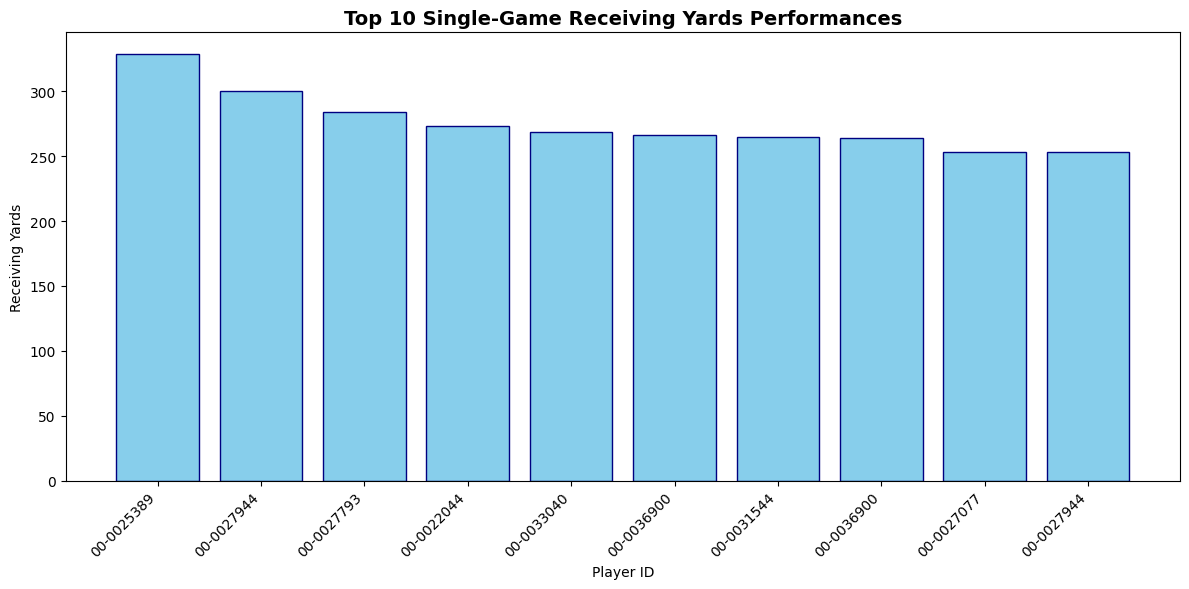

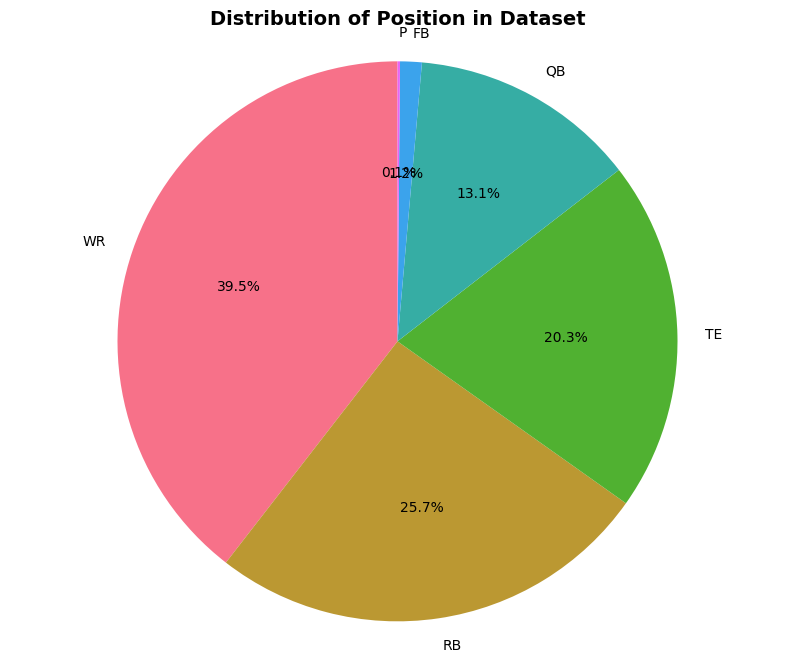

In [ ]:
player_cols = [col for col in weekly_offense.columns if 'player' in col.lower() or 'name' in col.lower()]
receiving_cols = [col for col in weekly_offense.columns if 'receiv' in col.lower()]
position_cols = [col for col in weekly_offense.columns if 'position' in col.lower() or 'pos' in col.lower()]

# Plot 1: Bar Chart - Top 10 Performances
plt.figure(figsize=(12, 6))

player_id_col = player_cols[0] if player_cols else 'player_id'
receiving_col = receiving_cols[0] if receiving_cols else [col for col in weekly_offense.columns if 'yard' in col.lower()][0]

top_data = weekly_offense.dropna(subset=[receiving_col]).nlargest(10, receiving_col)
top_players = top_data[player_id_col].astype(str)
top_yards = top_data[receiving_col]

plt.bar(range(len(top_players)), top_yards, color='skyblue', edgecolor='navy')
plt.xticks(range(len(top_players)), top_players, rotation=45, ha='right')
plt.title(f'Top 10 Single-Game {receiving_col.replace("_", " ").title()} Performances', fontsize=14, fontweight='bold')
plt.xlabel('Player ID')
plt.ylabel(receiving_col.replace("_", " ").title())
plt.tight_layout()
plt.show()

# Plot 2: Pie Chart - Position Distribution
plt.figure(figsize=(10, 8))

if position_cols:
    pos_col = position_cols[0]
    position_counts = weekly_offense[pos_col].value_counts().head(6)
    
    plt.pie(position_counts.values, labels=position_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("husl", len(position_counts)))
    plt.title(f'Distribution of {pos_col.replace("_", " ").title()} in Dataset', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.show()
else:
    categorical_cols = weekly_offense.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        backup_col = categorical_cols[0]
        cat_counts = weekly_offense[backup_col].value_counts().head(6)
        plt.pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title(f'Distribution of {backup_col.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        plt.axis('equal')
        plt.show()

How will you preprocess your data? Handle data imbalance if needed. You should only explain (do not perform pre-processing as that is in MS3) this in your README.md file and link your Jupyter notebook to it. All code and  Jupyter notebooks have be uploaded to your repo. (3 points)